# Introduction to Advanced Sampling Methods

Ludwig Schneider and Juan de Pablo

Pritzker School of Molecular Engineering

The University of Chicago

Berlin, July 28th, 2022

# Setting up the environment

First, we are setting up our environment. We use an already compiled and packaged installation of HOOMD-blue and the DLExt plugin.
We copy it from Google Drive and install PySAGES for it.

In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [4]:
%%bash
apt-cache policy libcudnn8 &> /dev/null
apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6 &> /dev/null
update-alternatives --auto libcudnn &> /dev/null

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.4.1.50-1+cuda11.6
  Version table:
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.2.44-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.2.44-1+cuda10.2

In [5]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.

In [6]:
%%bash

pip install -q --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null

Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.

In [7]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null

# Advanced Sampling Methods

In [8]:
%%bash

mkdir /content/advanced_sampling
cd /content/advanced_sampling

Many systems have a separated free-energy landscape, where different basins are divided by energy barriers.

### Examples:
#### Collective molecular transitions
* Protein folding
* Protein ligand binding
* Liqid membrane fusion

<img src=https://pubs.acs.org/cms/10.1021/ja910050x/asset/images/large/ja-2009-10050x_0008.jpeg width=500>

<img src=https://pubs.acs.org/cms/10.1021/ja910050x/asset/images/large/ja-2009-10050x_0011.jpeg width=500>

Smirnova, Yuliya G., et al. "Solvent-exposed tails as prestalk transition states for membrane fusion at low hydration." Journal of the American Chemical Society 132.19 (2010): 6710-6718

#### Phase transisions
* Liquid-vapor transisition
* Crystalization
* Shape transitions
* Magnetization (Ising model)

![picture](https://upload.wikimedia.org/wikipedia/commons/e/e6/Ising_quench_b10.gif)
Wikipedia: https://en.wikipedia.org/wiki/Ising_model

###Collective Variable (order parameter)

Usually, such transitions can be described in terms of order parameters/collective variables (CV).

$⇒$ Reduction of the phase space $\hat\xi(\{\vec{r}, \vec{p}\})$. In general, a collective variable can be multi-dimensional.

Examples:
* center of mass of molecule
* opening angle of protein
* magnetization
* [more common options in PySAGES](https://pysages.readthedocs.io/en/latest/module-pysages-colvars.html)

## Toy system: particle in multi-well


* a priori $A(\xi)$ is unknown
* but we can measure density of states $p(\xi)$

We can recover the free-energy profile from $p(\xi)$

$$A = - \frac{1}{\beta}\ln(Z)$$

* $A$: free-energy
* $Z$: partition function

We can formulate the partial partition function for a collective variable $\xi$

$$Z(\xi) = \int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i \delta (\hat\xi(\{\vec{r}, \vec{p}\}) e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}$$
Normalization:
$$p(\xi) = \frac{\int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i \delta (\hat\xi(\{\vec{r}, \vec{p}\} -\xi) e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}}{\int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}}$$

$$\Rightarrow A(\xi) = -\frac{1}{\beta} \ln(p(\xi)) + C$$
We can determine the free-energy profile $A(\xi)$ from the probability distribution $p(\xi)$.

With regular MC/MD a finite simulation trajectory is confined to a single basin as the probability of leaving the basin scales as

$$p \propto e^{-\beta \Delta E} \ll 1$$

* system might not equilibrate
* trajectory is not ergodic

### Computational realization via a toy system
Let's examine such a system via computer simulations.

*   fast to integration
*   custom bond potential to shape free-energy landscape

In [9]:
import numpy as np

def potential(x, rmin=0, rmax=100, amplitude=1, roughness=4, periodicity=1):
  energy = x**2
  energy += (1-np.exp(-x**2))*roughness*np.cos(periodicity*x*np.pi)
  energy *= amplitude
  force = 2*x
  force -= np.pi*periodicity*roughness*(1-np.exp(-x**2))*np.sin(periodicity*x*np.pi)
  force += 2*roughness*np.exp(-x**2)*x*np.cos(periodicity*x*np.pi)
  force *= -amplitude
  return energy, force

* customizable roughness and steepness
* symmeteric around the origin

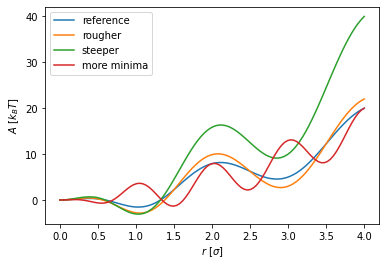

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel(r"$r$ $[\sigma]$")
ax.set_ylabel(r"$A$ $[k_B T]$")

x = np.linspace(0,4,100)
ax.plot(x, potential(x)[0], label="reference")
ax.plot(x, potential(x, roughness=6)[0], label="rougher")
ax.plot(x, potential(x, amplitude=2)[0], label="steeper")
ax.plot(x, potential(x, periodicity=2)[0], label="more minima")

# Uncommet to inspect the forces
# ax.plot(x, potential(x)[1], label="analytic force")
# ax.plot(x[:-1], -np.diff(potential(x)[0])/(x[1]-x[0]), label="numeric force")

ax.legend(loc="best")
fig.show()

* we can choose and adjust the potental


> Here we choose a system with multiple basins separated by energy barriers.


* use of a single bond to the phantom particle to realize the potential in HOOMD-blue

In [11]:
import hoomd
import hoomd.md

kBT=1

def generate_context(**kwargs):
    """
    Generates a simulation context, we pass this function to the attribute
    `run` of our sampling method.
    """
    fes_coeffs = kwargs.get("fes_coeffs", {"amplitude": 1, "roughness": 4, "periodicity": 1})
    hoomd.context.initialize("")

    ### System Definition
    snapshot = hoomd.data.make_snapshot(
        N = 2,
        box = hoomd.data.boxdim(Lx = 50, Ly = 50, Lz = 50),
        particle_types = ['P', 'G'],
        bond_types = ["bond"],
    )

    snapshot.particles.typeid[0] = 0
    snapshot.particles.typeid[1] = 1

    # Refernce particle at extension 2.8 and ghost particle at origin 
    positions = np.array([[2.8,  0,  0], [0, 0,  0]])

    snapshot.particles.position[:] = positions[:]

    snapshot.bonds.resize(1)
    snapshot.bonds.typeid[0] = 0

    snapshot.bonds.group[:] = [[0, 1]]

    hoomd.init.read_snapshot(snapshot)

    # Connect custom bond to create energy landscape
    fes = hoomd.md.bond.table(width=500)
    fes.bond_coeff.set("bond", func=potential, rmin=0, rmax=10, coeff=fes_coeffs)

    dt=1e-3
    hoomd.md.integrate.mode_standard(dt = dt)
    # We do not integrate the ghost particle
    integration_group = hoomd.group.type("P")
    integrator = hoomd.md.integrate.nvt(group = hoomd.group.all(), kT = kBT, tau = 100*dt)
    integrator.randomize_velocities(seed = 42)

    return hoomd.context.current

The bond realizes the custom energy landscape via a frozen particle in the center.
In this case, the energy is equivalent to free energy. This is only true, because of the simple nature of this toy system. Usually, the free energy is unknown and needs to be discovered via advanced sampling methods.


### Collective variable (order parameter)


Here we choose the distance from the origin as the collective variable.

We use PySAGES to define this collective variable.

In [12]:
from pysages.colvars import Distance
import pysages

# Distance from our particle to origin (particle 1)
cvs = [Distance( (0, 1))]

### Unbiased simulation
Next, we are interested in an unbiased simulation. PySAGES offers a special method for unbiased simulations, that can still record the collective variable.

In [13]:
from pysages.methods import Unbiased
method = Unbiased(cvs)

We also want to track the collective variable over time and as a histogram, so we can log it via PySAGES.

In [14]:
from pysages.methods.utils import HistogramLogger
hist = HistogramLogger(period=100)

We now simulate $1\times10^5$ time steps.
To investigate the unbiased trajectory and statistics.

In [15]:
result = pysages.run(method, generate_context, int(1e5), callback=hist)

HOOMD-blue v2.9.7 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 07/07/2022
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
no CUDA-capable device is detected
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:11 | Step 13259 / 100000 | TPS 1325.87 | ETA 00:01:05
Time 00:00:21 | Step 44282 / 100000 | TPS 3102.25 | ETA 00:00:17
Time 00:00:31 | Step 75455 / 100000 | TPS 3117.24 | ETA 00:00:07
Time 00:00:39 | Step 100000 / 100000 | TPS 3126.58 | ETA 00:00:00
Average TPS: 2641.76
---------
** run complete **


Let's see how the particle moved in this potential landscape.

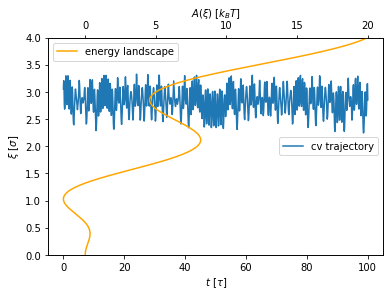

In [16]:
def plot_one_result(result):
  histogram_log = result.callbacks[0]
  cv_log = np.asarray(histogram_log.data)
  time = np.linspace(0, len(cv_log)*0.1, len(cv_log))
  fig, ax = plt.subplots()
  ax.set_xlabel(r"$t$ $[\tau]$")
  ax.set_ylim((0, 4))
  ax.set_ylabel(r"$\xi$ $[\sigma]$")

  ax.plot(time, cv_log, label="cv trajectory")

  ax2 = ax.twiny()
  ax2.set_xlabel(r"$A(\xi)$ $[k_BT]$")
  cv_range = np.linspace(0, 4, 200)
  ax2.plot(potential(cv_range)[0], cv_range, label="energy landscape", color="orange")

  ax.legend(loc="center right")
  ax2.legend(loc="upper left")
  fig.show()
plot_one_result(result)

We see, that the system actually never leaves the local minimum around $\xi=3$.
Since the phase space is not fully explored the prediction of the free energy is not complete. Here the system is not even equilibrated.


The sampling is not ergodic!
This is common for normal MD (although not as easy to spot usually).

###Solution: Biased simulations

Introducing a weight function $w(\xi(\{r,p\}))$ to allow phase space exploration.

$$p(\{(r,p)\}) \propto p_{eq}(\{r,p\})/w(\xi(\{r, p\}))$$
$p(\{(r,p)\})$ is the biased distribution, $p_{eq}$ refers to the unbiased equilibrium distribution.

Find the biase distribution as a function of the collective variable $\xi$.
$$p(\xi) = \int\text{d}r\text{d}p \delta(\xi - \hat\xi) p(\{(r,p\}))$$
$$p(\xi) = \int\text{d}r\text{d}p \delta(\xi - \hat\xi) \frac{p_{eq}(\{(r,p)\})}{w(\xi)}$$
$$p(\xi) = \frac{1}{w(\xi)} \int\text{d}r\text{d}p \delta(\xi - \hat\xi) p_{eq}(\{(r,p)\})$$
$$p(\xi) = \frac{p_{eq}(\{(r,p)\})}{w(\xi)} $$


*   with known distribution $p(\xi)$ (measured) and known weight $w(\xi)$, we can infer $p_{eq}$
*   optimal weight $w(\xi) = p_{eq}(\xi)$: almost random walk in $\xi$
*   optimal weight a priori unknown

For NVT MD we can modify the Hamiltonian to introduce a weight.
$$p(\{(r,p)\}) \propto e^{-\beta H^0(\{(p,r)\})} \frac{1}{w(\xi(\{(r,p)\}))} = e^{-\beta (H^0(\{(p,r)\})+H^w(\{(r,p)}))$$

$$\Rightarrow H^w(\{(r,p)\} = k_BT \ln(w(\xi(\{(r,p)\})))$$

Here is where [PySAGES](https://github.com/SSAGESLabs/PySAGES) comes into play! PySAGES allows you to easily (python code) introduce a biasing Hamiltonian into a given MD backend (like [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/), [OpenMM](https://openmm.org), or [ASE](https://wiki.fysik.dtu.dk/ase/)).
So it is not necessary to modify the MD backend and via [JAX](https://jax.readthedocs.io/en/latest/index.html) we offer automatic differentiation, so forces are calculated automatically.

## Harmonic Biasing

We can start biasing by using a simple harmonic biasing, where we bias the system towards one of the less explored regions in phase space.

$$H_B(r) = - k (c-r)^2\sigma^2$$ 

PySAGES offers a preimplemented method class, that we are utilizing.

In our example toy system, we choose $c=2\sigma$ as a maximum of our external potential.

We don't know a priori what a good spring constant is. Let's start with $k=1 k_BT$. 

In [17]:
from pysages.methods import HarmonicBias
method = HarmonicBias(cvs, kspring=1, center=2)
hist = HistogramLogger(period=100)
result = pysages.run(method, generate_context, int(1e5), callback=hist)

notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:10 | Step 28738 / 100000 | TPS 2873.77 | ETA 00:00:24
Time 00:00:20 | Step 59881 / 100000 | TPS 3114.24 | ETA 00:00:12
Time 00:00:30 | Step 90943 / 100000 | TPS 3106.16 | ETA 00:00:02
Time 00:00:33 | Step 100000 / 100000 | TPS 3042.29 | ETA 00:00:00
Average TPS: 3031.47
---------
** run complete **


Ok, we analyze the trajectory as before to see how the energy landscape is explored now.

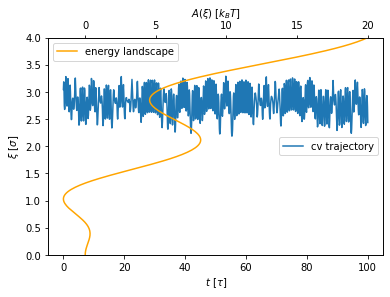

In [18]:
plot_one_result(result)

We observe that the free-energy barrier at $c=2$ is already much better explored, but the biasing force is not strong enough to pull the particle out of the free-energy minimum. Let's try $k=100k_BT$.

notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:10 | Step 28326 / 100000 | TPS 2832.6 | ETA 00:00:25
Time 00:00:20 | Step 58642 / 100000 | TPS 3031.6 | ETA 00:00:13
Time 00:00:30 | Step 89386 / 100000 | TPS 3074.38 | ETA 00:00:03
Time 00:00:33 | Step 100000 / 100000 | TPS 2937.66 | ETA 00:00:00
Average TPS: 2974.83
---------
** run complete **


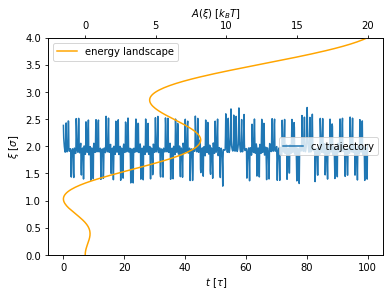

In [19]:
method = HarmonicBias(cvs, kspring=100, center=2)
hist = HistogramLogger(period=100)
result = pysages.run(method, generate_context, int(1e5), callback=hist)
plot_one_result(result)

Ok, now the system mostly oscillates around the maximum with two minima, but these two minima are not close to the actual minima of the free-energy landscape.

The spring constant is so strong, that restricts the exploration of the phase space too much. Let's try the middle ground instead $k=10k_BT$.

notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:10 | Step 28186 / 100000 | TPS 2818.53 | ETA 00:00:25
Time 00:00:20 | Step 57538 / 100000 | TPS 2935.15 | ETA 00:00:14
Time 00:00:30 | Step 87222 / 100000 | TPS 2968.38 | ETA 00:00:04
Time 00:00:34 | Step 100000 / 100000 | TPS 3004.38 | ETA 00:00:00
Average TPS: 2919.25
---------
** run complete **


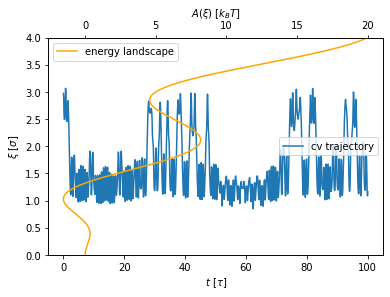

In [20]:
kspring=10
method = HarmonicBias(cvs, kspring=kspring, center=2)
hist = HistogramLogger(period=100)
result = pysages.run(method, generate_context, int(1e5), callback=hist)
plot_one_result(result)

This looks much better!

We observe multiple transitions between the minima at $c=1$ and $c=2$ (rare events), so the phase space is better explored. We also see that the lower minimum is frequented more than the upper one as expected.

We now analyze the histograms of this trajectory to determine the free-energy landscape $A(\xi)$ from the biased simulation.

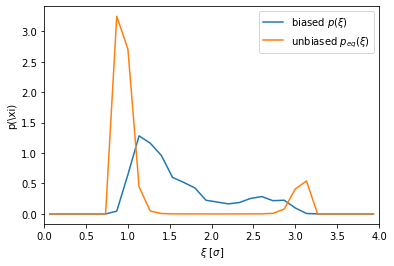

In [21]:
from scipy import integrate
def plot_one_histogram(result):
  histogram_log = result.callbacks[0]
  
  hist, edges = histogram_log.get_histograms(bins=30, range=[(0,4)])
  fig, ax = plt.subplots()
  ax.set_xlabel(r"$\xi$ $[\sigma]$")
  ax.set_ylabel(r"p(\xi)")
  ax.set_xlim((0, 4))

  x = edges[0][:-1] + np.diff(edges[0])/2
  ax.plot(x, hist, label=r"biased $p(\xi)$")
  weight = np.exp(-kspring*(x-2)**2)
  unbiased_distribution = hist/weight
  unbiased_distribution /= integrate.simpson(unbiased_distribution, x)
  ax.plot(x, unbiased_distribution, label=r"unbiased $p_{eq}(\xi)$")

  ax.legend(loc="best")
  fig.show()
plot_one_histogram(result)

We can see, that the unbiased distribution puts the minima in the wrong place, but correcting it with the weight gives us the correct minima positions. 
However, we can't be sure that this is the correct profile yet.

So let's compare to the expected free-energy profile.

$$A(\xi) = -k_BT \ln(p_{eq}(\xi) + C$$ 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


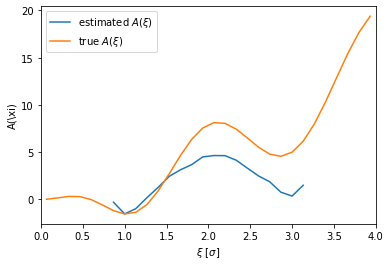

In [22]:
def plot_one_free_energy(result):
  histogram_log = result.callbacks[0]
  
  hist, edges = histogram_log.get_histograms(bins=30, range=[(0,4)])
  fig, ax = plt.subplots()
  ax.set_xlabel(r"$\xi$ $[\sigma]$")
  ax.set_ylabel(r"A(\xi)")
  ax.set_xlim((0, 4))

  x = edges[0][:-1] + np.diff(edges[0])/2

  weight = np.exp(-kspring/2*(x-2)**2)
  unbiased_distribution = hist/weight
  unbiased_distribution /= integrate.simpson(unbiased_distribution, x)

  estimated_profile = -kBT * np.log(unbiased_distribution)
  constant_C = -np.min(estimated_profile) + np.min(potential(x)[0])
  ax.plot(x, estimated_profile + constant_C, label=r"estimated $A(\xi)$")
  
  ax.plot(x, potential(x)[0], label=r"true $A(\xi)$")

  ax.legend(loc="best")
  fig.show()
plot_one_free_energy(result)

That estimation is not bad.
We get the approximate right shape in the middle and that could be further improved by running the sampling trajectory longer.
[Try it out!]

But there are still some issues because we still cannot sample the entire space:

*  we do not find the minima at 0
*  the up trend on the right is uncovered
*  the second minima is overestimated

Can we bias simulations in these regions too, to improve sampling coverage in these regions too?

## Umbrella Sampling

We want to find the free-energy profile along a given path in the space for collective variables. Usually, this path can be multidimensional.

Example dihedral angles of Alanine Dipeptide. [PySAGES Alanine Dipentide examples](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/openmm/Harmonic_Bias.ipynb)

<img src=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4715807/bin/nihms-706794-f0001.jpg width=500>


Wu, Xiongwu, Bernard R. Brooks, and Eric Vanden‐Eijnden. Journal of computational chemistry 37.6 (2016): 595-601.


<img src=https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep31232/MediaObjects/41598_2016_Article_BFsrep31232_Fig4_HTML.jpg width=500>


Bonomi, Massimiliano, Carlo Camilloni, and Michele Vendruscolo. Scientific reports 6.1 (2016): 1-11.

Downside: 

We need to know the path $\xi_0(t)$ we are interested in.

Goal: 

Obtain the free-energy profile along the path $A(\xi_0(t))$.


Discretize the path $\xi_0(t_i)$ and bias the simulation at each point $i$ along the path.

$$H^b(\{(r)\}) = H^b(\{(r)\}) + w_i(\xi(\{(r)\}))$$

$w_i$ biases the system close to $\xi_0(t_i)$ along the path.

$$p_i^u(\xi) = \frac{\int\text{d}r e^{-\beta H(r)} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta H(r)}}$$

$$p_i^b(\xi) = \frac{\int\text{d}r e^{-\beta[H(r) + w_i(\hat\xi(r))]} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta[H(r) + w_i(\hat\xi(r))]}}$$

$$  = e^{-\beta w_i(\xi)} \frac{\int\text{d}r e^{-\beta[H(r)} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta[H(r) + w_i(\hat\xi(r))]}}$$

$$\Rightarrow p_i^u(\xi) = p_i^b(\xi) e^{-\beta w_i(\xi)} \frac{\int \text{d} r e^{-\beta w_i(\xi(r))} e^{-\beta H(r)}}{\int\text{d}r e^{-\beta H(r)}}$$

So we can describe the last term as a thermal average.

$$\Rightarrow p_i^u(\xi) = p_i^b(\xi) e^{-\beta w_i(\xi)} \langle e^{-\beta w_i}\rangle$$

And the free energy is

$$A_i(\xi) = -k_BT \ln(p_i^b(\xi) - w_i(\xi) + F_i$$
With $F_i = -k_BT\ln(\langle e^{-\beta w_i}\rangle)$ as constant independent of $\xi$.

With a single biasing potential $F_i$ does not matter. $A(\xi)$ is defined up to a constant.

But if we want to combine multiple windows, we have to estimate it.

$$e^{-\beta F_i} = \langle e^{-\beta w_i}\rangle$$
$$ = \int \text{d} \xi p^u(\xi) e^{-\beta w_i(\xi)}$$
$$ = \int\text{d}\xi e^{-\beta [A(\xi) + w_i(\xi)}$$

not directly solvable.

### Shape of the potential

Ideal $w_i(\xi) = p_{eq}(\xi)$ and differentiable.

*  For now we harmonic potential
*  fix system with a spring to point on path.
$$w_i(\xi) = k/2 (\xi - \xi_0(t_i))^2$$
*  combine different points into one analysis

Example: 10 evenly spaced points between 0 and 4.

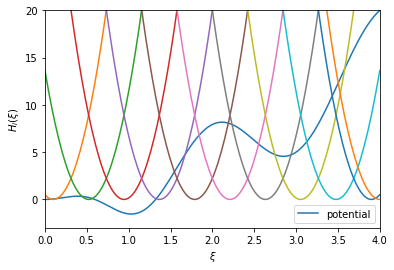

In [23]:
centers = list(np.linspace(1e-1, 4-1e-1, 10)) + [4]
kspring = 100
fig, ax = plt.subplots()
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$H_i(\xi)$")
ax.set_ylim((-3, 20))
ax.set_xlim((0,4))

x = np.linspace(0, 4, 200)
ax.plot(x, potential(x)[0], label="potential")
for point in centers:
  label = None
  if point == 0:
    label = "biasing potential"
  ax.plot(x, kspring/2*(x-point)**2, label=label)
ax.legend(loc="best")
fig.show()


*  one free parameter per window $k$
Goal: $\Rightarrow$ overlapping histograms

$$\int \text{d} \xi p_i^b(\xi) p_{i+1}^b(\xi) \gg 0$$

In [24]:
from pysages.methods import UmbrellaIntegration
method = UmbrellaIntegration(cvs, ksprings=kspring, centers=centers, hist_periods=100)
result = pysages.run(method, generate_context, int(1e5))

notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:10 | Step 28153 / 100000 | TPS 2815.22 | ETA 00:00:25
Time 00:00:20 | Step 58374 / 100000 | TPS 3022.05 | ETA 00:00:13
Time 00:00:30 | Step 88664 / 100000 | TPS 3028.97 | ETA 00:00:03
Time 00:00:33 | Step 100000 / 100000 | TPS 2985.81 | ETA 00:00:00
Average TPS: 2958.66
---------
** run complete **
notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** starting run **
Time 00:00:10 | Step 28518 / 100000 | TPS 2851.76 | ETA 00:00:25
Time 00:00:20 | Step 58912 / 100000 | TPS 3039.39 | ETA 00:00:13
Time 00:00:30 | Step 89502 / 100000 | TPS 3058.96 | ETA 00:00:03
Time 00:00:33 | Step 100000 / 100000 | TPS 3021.74 | ETA 00:00:00
Average TPS: 2987.14
---------
** run complete **
notice(2): Group "all" created containing 2 particles
notice(2): Group "type P" created containing 1 particles
** star

You can already see one downside, we have to run multiple replicas, which consume more computational resources.

Let's see what the histograms look like.

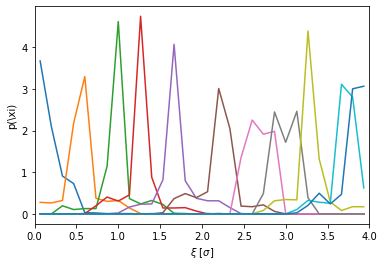

In [25]:
def plot_multi_histogram(result):
  fig, ax = plt.subplots()
  ax.set_xlabel(r"$\xi$ $[\sigma]$")
  ax.set_ylabel(r"p(\xi)")
  ax.set_xlim((0, 4))
  for histogram_log in result.callbacks:
    hist, edges = histogram_log.get_histograms(bins=30, range=[(0,4)])
    x = edges[0][:-1] + np.diff(edges[0])/2
    ax.plot(x, hist, label=r"biased $p(\xi)$")
  fig.show()
plot_multi_histogram(result)

The result is OK, good enough for our test case here. We have some overlap between the histograms.

### Umbrella Integration

Now, how can we combine these histograms into a single free-energy profile?

$$A_i(\xi) = -k_BT \ln(p_i^b(\xi) - w_i(\xi) + F_i$$


One option is weighted histogram analysis (WHAM), but that works best for one-dimensional collective variables. (Implement it yourself, all you need from PySAGES is available.)

Here we are using a simple umbrella integration instead.

Idea: differentiate by $\xi$ to eliminate $F_i$.

$$\frac{\partial A_i^u}{\partial \xi} = - k_BT \frac{\partial \ln(p_i^b(\xi))}{\partial \xi} - \frac{\partial w_i(\xi)}{\partial \xi}$$

For this we approximate $p_i^b(\xi)$ as a Gaussian with the mean $\bar\xi_i$ and variance $\sigma_i^b$.

$$p_i^b(\xi) = \frac{1}{\sigma_i^b \sqrt{2\pi}} e^{-\frac{1}{2} \frac{(\xi-\xi_i^b)^2}{\sigma_i^{b2}}}$$

approximating up to second order gives us 

$$\frac{\partial A_i^u}{\partial \xi} = - k_BT \frac{\xi-\hat\xi_i}{\sigma_i^{b2}} - k_i (\xi - \xi_0(t_i)).$$
We can also approximate up to first order only
$$\frac{\partial A_i^u}{\partial \xi} =  k_i (\xi - \xi_0(t_i)),$$
which is easily expandable to higher order collective variables and the implementation in PySAGES.

Now we can combine all these windows

$$\frac{\partial A}{\partial \xi} = \sum_i p_i(\xi) \frac{\partial A}{\partial \xi}$$
with
$$p_i(\xi) = \frac{a_i(\xi)}{\sum_j a_j(\xi)}$$
and
$$a_i(\xi) = N_i p_i^b(\xi)$$
with $N_i$ being the number of samples in window $i$.

And integrate the derivative for the profile numerically.

*  this averages the mean-force
*  we are approximating the distribution
*  easy to generalize in higher dimensions

Let's see how PySAGES analyzes it for us and produces the free-energy result.


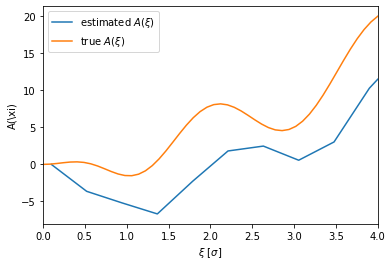

In [26]:
def plot_umbrella_free_energy(result):
  processed_result = pysages.analyze(result)
  
  fig, ax = plt.subplots()
  ax.set_xlabel(r"$\xi$ $[\sigma]$")
  ax.set_ylabel(r"A(\xi)")
  ax.set_xlim((0, 4))

  ax.plot(processed_result["centers"], processed_result["free_energy"], label=r"estimated $A(\xi)$")
  x = np.linspace(0, 4, 50)
  ax.plot(x, potential(x)[0], label=r"true $A(\xi)$")

  ax.legend(loc="best")
  fig.show()
plot_umbrella_free_energy(result)

This appears to be much better.
Even with the crude approximations, we were doing we can estimate the shape of the potential.

Just the beginning at very small $\xi$ are overestimating the decrease in the free-energy initially.
This is an issue with umbrella integration, where histograms at the edge of windows are not correctly analyzed.
There is a fix for this in the literature [Kästner, Johannes. "Umbrella sampling." Wiley Interdisciplinary Reviews: Computational Molecular Science 1.6 (2011): 932-942.](https://wires.onlinelibrary.wiley.com/doi/abs/10.1002/wcms.66) but this is out of scope for our introduction here.

Can we do better than this?
Yes, of course:
*  [Meta-dynamics](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/hoomd-blue/Umbrella_Integration.ipynb): approximate one weight function with a sum of Gaussians
*  [ANN](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/hoomd-blue/Butane_ANN.ipynb): approximate biasing force with artificial neuronal networks (ANN)

## GPU computing

This example was using a single CPU core only.
For a realistic system, GPU acceleration is required.

What do we have to do to run this code on a GPU?

Nothing!

Just change the runtime environment to GPU and you are good to go.
Or run your examples on the GPU accelerated workstation.

PySAGES is preinstalled, so you are good to go!

## String algorithm

We can determine the profile of free energy now.
In more than one dimension the profile depends on the path taken.


<img src=https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep31232/MediaObjects/41598_2016_Article_BFsrep31232_Fig4_HTML.jpg width=500>


Bonomi, Massimiliano, Carlo Camilloni, and Michele Vendruscolo. Scientific reports 6.1 (2016): 1-11.

So how do we find the minimum (free) energy path (MEP)?

This path runs through a valley of the free-energy landscape and has the smallest free-energy barrier. Hence it is the most likely kinetic path.

The formal definition of this path is that the forces on a state point are always parallel (up or down not sideways) to the path.

$$\xi_0(t) \parallel \Delta V$$
The normal component of the force $\Rightarrow \Delta V^\perp = 0$ is zero.

General Idea:

Move the string (path) along the perpendicular component $\Delta V^\perp$ at each discretized point $v_i = - \Delta V^\perp$. (Gradient descent)
The parallel component would move the discretized point just along the path and end up in the minima.

Problem 1:

How to get $\Delta V$? [Especially if it is a free-energy]

Solution: Harmonic biased simulations at each replica of the string

$$\Delta V|_{t_i} = - k \langle \xi_0(t_i) - \xi \rangle$$

[computationally expensive]

Problem 2:

How to get the perpendicular component?
*  the discretization of the path is rough

Solution: use a cubic spline-interpolation

*  piece-wise 3rd order polynomial
*  easy to parameterize
*  easy to interpolate
*  differentiable

$\Rightarrow$ perpendicular component $\Delta V^\perp$!
$\Rightarrow$ smooth path $\xi_0^s(t) with $\xi_0^s(t) = \xi(t_i)$.

#### Improved string method

Using the perpendicular component directly does not lead to good convergences.
Instead, we can use the improved string method.

Iterate:

1.   Calculate $\Delta V|_{t_i}$
2.   Move string $\xi_0(t_i)$ += $\alpha \Delta V|_{t_i}$
3.   Calculate spline $\xi_0^s(t)$
4.   Re-parametrize the string points.
> Such that $|\xi_0^s(t_i) - \xi_0^s(t_{i+1})| = $const.
> *  cancels out parallel force component
> *  well discretized string
> *  requires a norm in $\xi$ space. For example $L^2$ norm in $\xi$ space.

Stop iteration if converged and test $\Delta V^\perp = 0$.
* typically slow convergence

With the converged path, calculate the free-energy profile using umbrella integration.

## What is a good collective variable?

Let us define a committor probability.

For a given point $r_i$ we can define the probability that a simulation started from this point ends in minima $B$ first before it moves through $B$.
$$\text{commitor probability B: } p_B(r_i)$$

This is a probability since we can have multiple realizations of $r_i$ in momentum space (Maxwell-Boltzmann distribution). Each of these realizations has its path and we simulate them and measure if they arrive in $A$ or $B$ first.

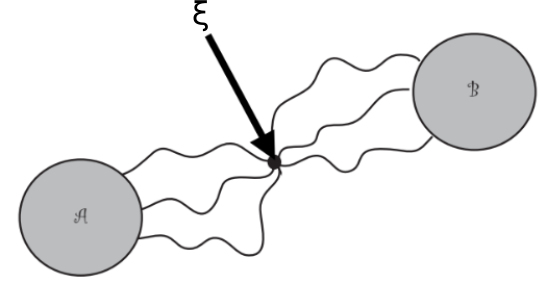

Intuitively, if $\xi$ is at the halfway point of the path ($t=1/2$) the committor probability should be $1/2$.
And the probability decreases if we move towards $A$ ($t < 1/2$) the probability should also decrease $p_B(t < 1/2) < 1/2$ and vice versa $p_B(t>1/2) > 1/2$.


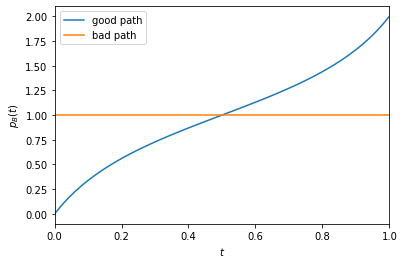

In [27]:
fig, ax =plt.subplots()
ax.set_xlabel("$t$")
ax.set_xlim((0,1))
ax.set_ylabel("$ p_B(t)$")

x = np.linspace(0, 1, 50)
p_good = np.tan(2*(x-.5))
p_good -= np.min(p_good)
p_good /= integrate.simpson(p_good, x)
p_bad = x*0+1
p_bad /= integrate.simpson(p_bad, x)

ax.plot(x, p_good, label="good path")
ax.plot(x, p_bad, label="bad path")

ax.legend(loc="best")
fig.show()

We can generalize this concept to the entire space.

First, the isosurfaces of the collective variable are all points in space $(r,p)$ where $\xi((r,p))=c$ are equal and $c$.
In our example, the sphere around the origin with distance $c=0.5$.

We can also define isosurfaces for the committor probabilities.
All points in space where the committor probabilities are equal $p_B(r_i) =c$.

For a descriptive collective variable, we want that when changing $\xi$ the committor probability changes equally.
This is best ensured if the isosurfaces of the collective variables are aligned with the isosurfaces of committor probabilities.

Usually, calculating committor probabilities is computationally so expensive that it is prohibitive. But it is a way to check results in case of doubt about collective variables.

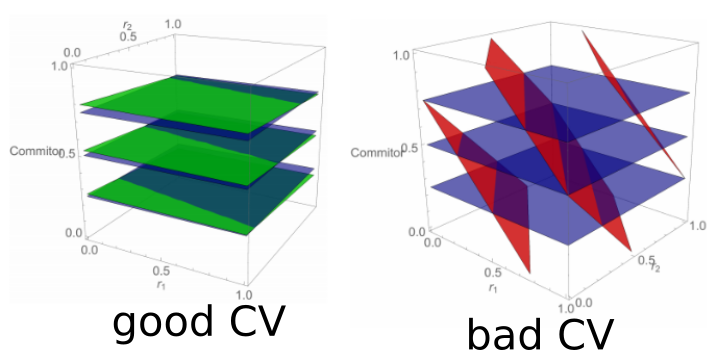